In [24]:
import numpy as np
import pandas as pd
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from tensorflow import keras
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn
from sklearn.decomposition import PCA
import random

In [25]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 1

In [26]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [27]:
latent_dim = 10
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [str(latent_space_column) for latent_space_column in latent_space_columns]

In [28]:
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)

In [29]:
def generate_latent_df(latent_df):
    meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)

    # fill negative control DMSO profiles, change the NaN MOA label to be DMSO
    meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

    #drop profiles with NaN MOAs
    meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)

    # add columns to the dataframe that are randomnly shuffled permutations of the MOA column
    for i in range(NUM_RANDOM_SAMPLES):
        random_moa_labels = meta_moa_latent_df[['moa','Metadata_dose_recode']].sample(frac=1).reset_index(drop=True)    
        random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i), 'Metadata_dose_recode': 'random_dose' + str(i)})
        meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
        
    return meta_moa_latent_df

In [30]:
vae_latent_df = pd.read_csv("level5Latent.csv").drop("Unnamed: 0", axis = 1)

In [31]:
pca = PCA(n_components=latent_dim)
pca_latent_df = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)

In [32]:
meta_moa_vae_latent_df = generate_latent_df(vae_latent_df)
meta_moa_pca_latent_df = generate_latent_df(pca_latent_df)
meta_moa_complete_df = generate_latent_df(complete_features_df)

In [33]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

#We only want moa combinations with enough data, so we pick A|B such that there are at least 5 A|B, 5 A, and 5 B.
valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 0) & (moas_occurrence['moa1 occurrence'] > 0)& (moas_occurrence['moa2 occurrence'] > 0)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [34]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

In [35]:
#calculate means for each A and B in each A|B.
def calculate_means(meta_moa_latent_df, columns):
    subset_means = []
    subset_random_means = []

    for pipe in valid_pipes:
        subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
        subset_mean = subset.groupby(['moa','Metadata_dose_recode'])[columns].mean()

        subsets_random_mean = []
        for i in range(NUM_RANDOM_SAMPLES):
            moa_label = 'random_moa_labels' + str(i)
            dose_label = 'random_dose' + str(i)
            subset_random = subset_by_moa(pipe, meta_moa_latent_df, moa_label)
            subset_random_mean = subset_random.groupby([moa_label, dose_label])[columns].mean()
            subsets_random_mean.append(subset_random_mean)

        subset_means.append(subset_mean)

        subset_random_means.append(subsets_random_mean)
    
    return subset_means, subset_random_means

In [36]:
subset_vae_means, subset_vae_random_means = calculate_means(meta_moa_vae_latent_df, latent_space_columns)
subset_pca_means, subset_pca_random_means = calculate_means(meta_moa_pca_latent_df, latent_space_columns)
subset_complete_means, subset_complete_random_means = calculate_means(meta_moa_complete_df, complete_features_df.columns)

In [37]:
#calculate means for DMSO
def calculate_dmso_means(meta_moa_latent_df, columns):
    DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
    DMSO_means = np.mean(DMSO[columns])

    DMSO_means_random = []

    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
        DMSO_means_random.append(np.mean(DMSO_random[columns]))
    return DMSO_means, DMSO_means_random

In [38]:
DMSO_vae_means, DMSO_vae_means_random  = calculate_dmso_means(meta_moa_vae_latent_df, latent_space_columns)
DMSO_pca_means, DMSO_pca_means_random = calculate_dmso_means(meta_moa_pca_latent_df, latent_space_columns)
DMSO_complete_means, DMSO_complete_means_random = calculate_dmso_means(meta_moa_complete_df, complete_features_df.columns)

In [39]:
def determine_overlapping_doses(subset_mean):
    overlapping_doses = []
    doses = subset_mean.index.get_level_values(1).to_list()
    for i in range(max(doses)):
        if doses.count(i) >= 2:
            overlapping_doses.append(i)
    return overlapping_doses

In [40]:
def LSA(A, B, D):
    return A-D+B

In [41]:
#perform latent space arithmetic
def generate_post_LSA_representations(subset_means, subset_random_means, DMSO_means, DMSO_means_random):
    representations_after_LSA = []
    representations_after_LSA_random = []

    for i in range(len(subset_means)):
        doses = determine_overlapping_doses(subset_means[i])
        representations_after_LSA_per_dose = []
        representations_after_LSA_random_per_dose = []
        
        for dose in doses:
            representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_means[i].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means)
            representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
            representation_after_LSA.index = [dose]
            representations_after_LSA_per_dose.append(representation_after_LSA)

            LSA_random_1pipe = []
            for j in range(NUM_RANDOM_SAMPLES):
                representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]].loc[dose],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]].loc[dose],DMSO_means_random[j])
                representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
                representation_after_LSA_random.index = [dose]
                LSA_random_1pipe.append(representation_after_LSA_random)    

            representations_after_LSA_random_per_dose.append(LSA_random_1pipe)

        representations_after_LSA.append(representations_after_LSA_per_dose)
        representations_after_LSA_random.append(representations_after_LSA_random_per_dose)
    
    return representations_after_LSA, representations_after_LSA_random

In [42]:
representations_after_LSA_vae, representations_after_LSA_vae_random = generate_post_LSA_representations(subset_vae_means, subset_vae_random_means, DMSO_vae_means, DMSO_vae_means_random)
representations_after_LSA_pca, representations_after_LSA_pca_random = generate_post_LSA_representations(subset_pca_means, subset_pca_random_means, DMSO_pca_means, DMSO_pca_means_random)
representations_after_LSA_complete, representations_after_LSA_complete_random = generate_post_LSA_representations(subset_complete_means, subset_complete_random_means, DMSO_complete_means, DMSO_complete_means_random)

In [43]:
np.shape(subset_vae_means)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(84,)

In [44]:
decoder = keras.models.load_model("../2.train/level5Decoder")

In [45]:
#decode each latent space representation
def decode_LSA_representations(representations_after_LSA, representations_after_LSA_random, model):
    predictions = []
    predictions_random = []

    for i in range(len(representations_after_LSA)):

        predictions_per_dose = pd.DataFrame()
        predictions_random_per_dose = {}

        for dose in range(len(representations_after_LSA[i])):
            if model == 'vae':
                prediction = decoder.predict(representations_after_LSA[i][dose])
            elif model == 'pca':
                prediction = pca.inverse_transform(representations_after_LSA[i][dose])
            elif model == 'complete':    
                prediction = representations_after_LSA[i][dose].values.tolist()
            else:
                print('"model" parameter must be "vae", "pca", or "complete"')
            prediction = pd.DataFrame(prediction)
            prediction.index = representations_after_LSA[i][dose].index
            predictions_per_dose = predictions_per_dose.append(prediction)
            
            predictions_random_1pipe = []

            for j in range(NUM_RANDOM_SAMPLES):
                if model == 'vae':
                    prediction_random = decoder.predict(representations_after_LSA_random[i][dose][j])
                elif model == 'pca':
                    prediction_random = pca.inverse_transform(representations_after_LSA_random[i][dose][j])
                elif model == 'complete':
                    prediction_random = representations_after_LSA_random[i][dose][j].values.tolist()
                else:
                    print('"model" parameter must be "vae", "pca", or "complete"')
                
                predictions_random_1pipe.append(prediction_random)
                
            
            predictions_random_per_dose[representations_after_LSA[i][dose].index[0]] = predictions_random_1pipe
            
        predictions.append(predictions_per_dose)
        predictions_random.append(predictions_random_per_dose)


    predictions = np.array(predictions)
    predictions_random = np.array(predictions_random)
    
    return predictions, predictions_random

In [46]:
predictions_vae, predictions_vae_random = decode_LSA_representations(representations_after_LSA_vae, representations_after_LSA_vae_random, 'vae')
predictions_pca, predictions_pca_random = decode_LSA_representations(representations_after_LSA_pca, representations_after_LSA_pca_random, 'pca')
predictions_complete, predictions_complete_random = decode_LSA_representations(representations_after_LSA_complete, representations_after_LSA_complete_random, 'complete')

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [47]:
np.shape(representations_after_LSA_vae)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(84,)

In [48]:
mean_of_moas = meta_moa_complete_df.groupby(['moa','Metadata_dose_recode']).mean().loc[:,'Cells_AreaShape_FormFactor':]
mean_of_moas = mean_of_moas[mean_of_moas.index.get_level_values(0).str.contains('\|')]

In [49]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
def calculate_L2_distances(predictions, predictions_random):
    L2 = []
    L2_per_dose = {}
    L2_random = []
    
    moa_dose = []
    per_moa_pvalues = []
    per_moa_tstat = []

    for i in range(len(predictions)):
        doses_1 = predictions[i].index.to_list()
        doses_2 = mean_of_moas[mean_of_moas.index.get_level_values(0) == valid_pipes[i]].index.get_level_values(1).to_list()
        doses = [dose for dose in doses_1 if dose in doses_2]
        for dose in doses:
            desired_moa = np.array(mean_of_moas[(mean_of_moas.index.get_level_values(0) == valid_pipes[i]) 
                                                & (mean_of_moas.index.get_level_values(1) == dose)])

            L2_distance = np.linalg.norm(predictions[i].loc[dose]-desired_moa[0])
            L2.append(L2_distance)
            if dose not in L2_per_dose:
                L2_per_dose[dose] = []
            L2_per_dose[dose].append(L2_distance)

            L2_random_per_moa = []
            for j in range(NUM_RANDOM_SAMPLES):
                L2_distance_random = np.linalg.norm(predictions_random[i][dose][j][0]-desired_moa[0])
                L2_random_per_moa.append(L2_distance_random)

            L2_random += L2_random_per_moa

            tstat, pval = ttest_1samp(L2_random_per_moa, L2_distance)

            moa_dose.append(valid_pipes[i] + ' ' + str(dose))
            per_moa_pvalues.append(pval)
            per_moa_tstat.append(tstat)
    return L2_per_dose, L2, L2_random, moa_dose, per_moa_pvalues, per_moa_tstat

In [50]:
L2_vae_per_dose, L2_vae, L2_vae_random, moa_dose_vae, per_moa_pvalues_vae, per_moa_tstat_vae = calculate_L2_distances(predictions_vae, predictions_vae_random)
L2_pca_per_dose, L2_pca, L2_pca_random, moa_dose_pca, per_moa_pvalues_pca, per_moa_tstat_pca = calculate_L2_distances(predictions_pca, predictions_pca_random)
L2_complete_per_dose, L2_complete, L2_complete_random, moa_dose_complete, per_moa_pvalues_complete, per_moa_tstat_complete = calculate_L2_distances(predictions_complete, predictions_complete_random)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/s

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/s

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/s

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/s

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/s

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/s

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/numpy/core/_method

In [51]:
per_moa_performance_df = pd.DataFrame({"MOA_dose":moa_dose_vae,"vae pvalue":per_moa_pvalues_vae,"vae tstat":per_moa_tstat_vae,"pca pvalue":per_moa_pvalues_pca,"pca tstat":per_moa_tstat_pca})
per_moa_performance_df.to_csv('ttest_per_moa.tsv', sep = '\t')


In [52]:
per_moa_performance_df = per_moa_performance_df.sort_values('vae tstat')
per_moa_performance_df

,MOA_dose,vae pvalue,vae tstat,pca pvalue,pca tstat
0,NFkB pathway inhibitor|proteasome inhibitor 1,NaN,NaN,NaN,NaN
1,NFkB pathway inhibitor|proteasome inhibitor 2,NaN,NaN,NaN,NaN
2,NFkB pathway inhibitor|proteasome inhibitor 3,NaN,NaN,NaN,NaN
3,NFkB pathway inhibitor|proteasome inhibitor 4,NaN,NaN,NaN,NaN
4,NFkB pathway inhibitor|proteasome inhibitor 5,NaN,NaN,NaN,NaN
...,...,...,...,...,...
415,adrenergic receptor agonist|serotonin receptor...,NaN,NaN,NaN,NaN
416,adrenergic receptor agonist|serotonin receptor...,NaN,NaN,NaN,NaN
417,adrenergic receptor agonist|serotonin receptor...,NaN,NaN,NaN,NaN
418,adrenergic receptor agonist|serotonin receptor...,NaN,NaN,NaN,NaN


In [53]:
well_predicted = per_moa_performance_df[per_moa_performance_df['vae tstat'] < 0]
well_predicted.to_csv('well_predicted_level5.csv')
well_predicted.head(20)

,MOA_dose,vae pvalue,vae tstat,pca pvalue,pca tstat


In [54]:
L2_vae_df = pd.DataFrame(L2_vae, columns = ['VAE Unshuffled'])
L2_vae_random_df = pd.DataFrame(L2_vae_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_complete_df = pd.DataFrame(L2_complete, columns = ['Complete Unshuffled'])
L2_complete_random_df = pd.DataFrame(L2_complete_random, columns = ['Complete Shuffled'])
L2_df = pd.concat([L2_vae_df, L2_vae_random_df, L2_pca_df, L2_pca_random_df, L2_complete_df, L2_complete_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled','Complete Unshuffled','Complete Shuffled']
L2_df.to_csv('L2_general.tsv', sep = '\t')

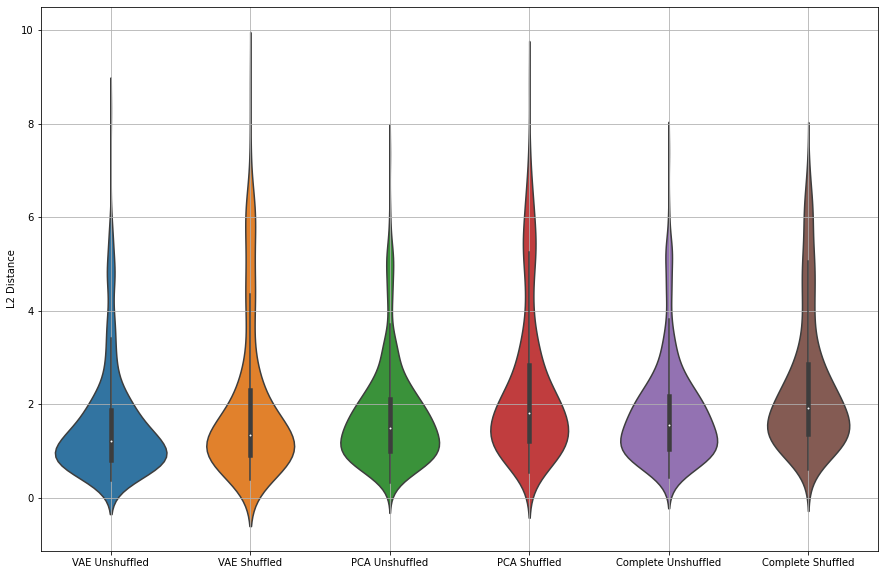

In [55]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(15, 10))
ax = seaborn.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [56]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled,Complete Unshuffled,Complete Shuffled
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,1.569104,1.989002,1.746006,2.338302,1.808736,2.398441
std,1.166976,1.643612,1.066890,1.589500,1.072871,1.455257
min,0.353465,0.381628,0.319346,0.529527,0.421866,0.593613
25%,0.814716,0.913335,1.014898,1.212026,1.055859,1.368648
50%,1.211580,1.354845,1.506157,1.825805,1.571191,1.921510
75%,1.880118,2.300055,2.111716,2.839299,2.179146,2.860808
max,8.299658,8.986188,7.360419,8.824928,7.406543,7.170937


In [57]:
# computing a 2-tailed 2-sample t-test. In the paper, we compute the one-tailed p-value by dividing the follwing p-value by 2
print(ttest_ind(L2_df['VAE Unshuffled'].dropna(), L2_df['VAE Shuffled']))
print(ttest_ind(L2_df['PCA Unshuffled'].dropna(), L2_df['PCA Shuffled']))
print(ttest_ind(L2_df['Complete Unshuffled'].dropna(), L2_df['Complete Shuffled']))
#1.29


Ttest_indResult(statistic=-4.269038289653694, pvalue=2.1875636643949974e-05)
Ttest_indResult(statistic=-6.340743838948871, pvalue=3.7343914366846237e-10)
Ttest_indResult(statistic=-6.684421273891221, pvalue=4.2284243406074164e-11)


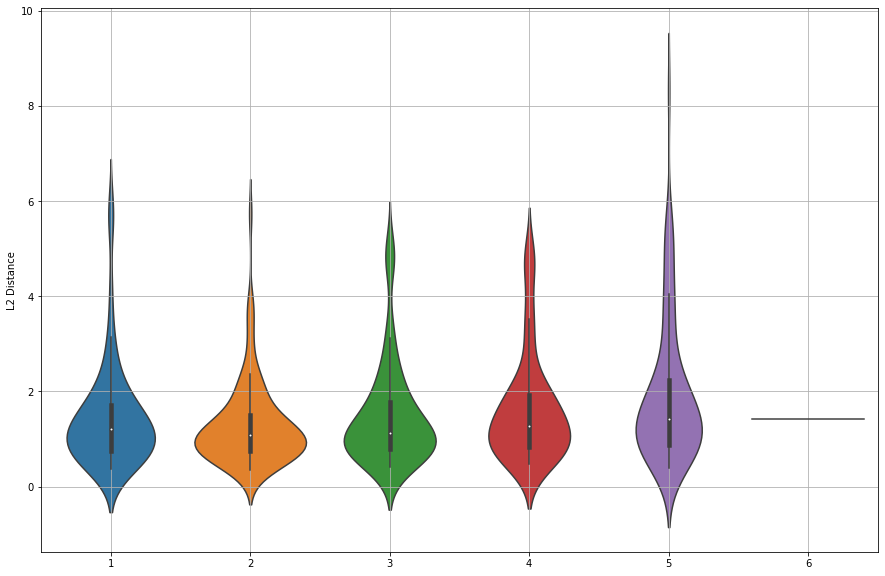

In [58]:
L2_vae_per_dose_df = pd.DataFrame.from_dict(L2_vae_per_dose, orient='index').transpose()
fig, ax = plt.subplots(figsize=(15, 10))
ax = seaborn.violinplot(data = L2_vae_per_dose_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [59]:
L2_vae_per_dose_df.describe()

,1,2,3,4,5,6
count,84.000000,84.000000,84.000000,84.000000,83.000000,1.000000
mean,1.460472,1.303385,1.502172,1.639014,1.946760,1.418885
std,1.106512,0.878077,1.079425,1.134313,1.489478,NaN
min,0.378354,0.353465,0.408393,0.477417,0.382904,1.418885
25%,0.752201,0.746072,0.785975,0.825211,0.880234,1.418885
50%,1.207606,1.085360,1.135659,1.275927,1.419129,1.418885
75%,1.718675,1.509057,1.771368,1.932403,2.241514,1.418885
max,5.969342,5.737143,5.094509,4.923293,8.299658,1.418885
